<a href="https://colab.research.google.com/github/Seng-Pan/ml_project/blob/main/ML_Project_Image_Classification_Knn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import pickle
import os
import json
from pathlib import Path
from tensorflow.keras.datasets import cifar100
from scipy.stats import randint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

base_path = Path("/content/drive/MyDrive/ml_project")

Mounted at /content/drive


Load Dataset

In [4]:
def check_data_validity(X, name='Data'):
    """Check for NaNs, Infs, or unusually large values in the data."""
    if np.isnan(X).any():
        print(f"⚠️ {name} contains NaN values.")
    if np.isinf(X).any():
        print(f"⚠️ {name} contains Inf values.")
    if np.any(np.abs(X) > 1e10):
        print(f"⚠️ {name} contains unusually large values.")

In [5]:
def load_and_preprocess_data():
    print("Loading CIFAR-100 dataset...")
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

    X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

    print(f"Data loaded and preprocessed.")
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Number of classes: {len(np.unique(y_train))}")

    return X_train, y_train, X_test, y_test


In [6]:
def apply_pca(X_train, X_test, n_components=100):
    print(f"Applying PCA to reduce dimensions to {n_components}...")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    check_data_validity(X_train_scaled, name="X_train_scaled")

    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    check_data_validity(X_train_pca, name="X_train_pca")
    check_data_validity(X_test_pca, name="X_test_pca")

    X_train_pca = np.nan_to_num(X_train_pca, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_pca = np.nan_to_num(X_test_pca, nan=0.0, posinf=0.0, neginf=0.0)

    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"Explained variance with {n_components} components: {explained_variance:.2f}%")

    return X_train_pca, X_test_pca, pca, scaler

In [7]:
def calculate_far_tar(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    far, tar = [], []

    for i in range(len(cm)):
        tp = cm[i,i]
        fp = sum(cm[:,i]) - tp
        tn = sum(sum(cm)) - sum(cm[i,:]) - sum(cm[:,i]) + tp
        fn = sum(cm[i,:]) - tp

        far_class = fp / (fp + tn) if (fp + tn) > 0 else 0
        tar_class = tp / (tp + fn) if (tp + fn) > 0 else 0

        far.append(far_class)
        tar.append(tar_class)

    return np.mean(far), np.mean(tar)

In [8]:
def train_knn(X_train, y_train, X_test, y_test, use_grid_search=False):
    print("\nTraining KNN classifier...")
    start_time = time.time()

    check_data_validity(X_train, name="Final X_train before KNN")

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    if use_grid_search:
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'p': [1, 2],
            'leaf_size': [10, 20, 30, 50]
        }
        knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy', return_train_score=True)
    else:
        param_dist = {
            'n_neighbors': randint(1, 20),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree'],
            'p': [1, 2],
            'leaf_size': randint(10, 50)
        }
        knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=20, cv=cv, n_jobs=-1, verbose=2, random_state=42, scoring='accuracy', return_train_score=True)

    knn.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = knn.best_estimator_.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    far, tar = calculate_far_tar(y_test, y_pred)

    print("\nTest set metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"FAR: {far:.4f}")
    print(f"TAR: {tar:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    return knn.best_estimator_, {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1,
        'far': far, 'tar': tar, 'training_time': training_time,
        'best_params': knn.best_params_, 'cv_results': knn.cv_results_
    }


In [9]:
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (list, tuple)):
        return [make_serializable(v) for v in obj]
    else:
        return obj

def save_model_and_metrics(model, metrics, pca, scaler):
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Save model
    with open(Path(base_path / 'knn_model.pkl'), 'wb') as f:
        pickle.dump(model, f)

    # Save PCA and scaler
    with open(Path(base_path / 'pca.pkl'), 'wb') as f:
        pickle.dump(pca, f)
    with open(Path(base_path / 'scaler.pkl'), 'wb') as f:
        pickle.dump(scaler, f)

    serializable_metrics = make_serializable(metrics)
    with open(base_path / 'metrics.json', 'w') as f:
        json.dump(serializable_metrics, f, indent=4)

    print("Model and metrics saved.")

In [23]:
def plot_results(metrics):
    keys = ['accuracy', 'precision', 'recall', 'f1_score', 'tar', 'far']
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TAR', 'FAR']
    values = [metrics[k] for k in keys]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values, color=['blue', 'green', 'orange', 'red', 'purple', 'brown'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

    plt.title('KNN Classifier Performance Metrics')
    plt.ylim(0, 1.1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(base_path / 'metrics_plot.png')
    plt.show()


### main test

In [11]:
def main(use_subset=True, pca_components=100, use_grid_search=False):
    """Main function to orchestrate the workflow"""

    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # If using a subset for faster execution (during development)
    if use_subset:
        X_train, y_train = X_train[:10000], y_train[:10000]
        X_test, y_test = X_test[:2000], y_test[:2000]

    # Apply PCA for dimensionality reduction
    X_train_pca, X_test_pca, pca, scaler = apply_pca(X_train, X_test, n_components=pca_components)

    # Train and evaluate KNN
    knn_model, metrics = train_knn(X_train_pca, y_train, X_test_pca, y_test, use_grid_search)

    # Save model and metrics
    save_model_and_metrics(knn_model, metrics, pca, scaler)

    # Plot results
    plot_results(metrics)

    print("\nTraining and evaluation completed!")

    return knn_model, metrics


In [12]:
if __name__ == "__main__":
    USE_GRID_SEARCH = True
    USE_SUBSET = True
    PCA_COMPONENTS = 200

    knn_model, metrics = main(use_subset=USE_SUBSET, pca_components=PCA_COMPONENTS, use_grid_search=USE_GRID_SEARCH)

    def make_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [make_serializable(i) for i in obj]
        else:
            return obj

    serializable_metrics = make_serializable(metrics)
    with open(Path(base_path / "metrics.json"), "w") as f:
        json.dump(serializable_metrics, f)


Loading CIFAR-100 dataset...
169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Data loaded and preprocessed.
Training data shape: (50000, 3072)
Testing data shape: (10000, 3072)
Number of classes: 100
Applying PCA to reduce dimensions to 200...
Explained variance with 200 components: 94.98%

Training KNN classifier...
Fitting 3 folds for each of 288 candidates, totalling 864 fits

Test set metrics:
Accuracy: 0.1350
Precision: 0.1861
Recall: 0.1350
F1 Score: 0.1267
FAR: 0.0087
TAR: 0.1370

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        24
           3       0.50      0.05      0.08        22
           4       0.12      0.43      0.18        14
           5       0.25      0.06      0.09        18
           6       0.50      0.04      0.08        23
           7       0.00      0.00      0.00    

KeyError: 'f1 score'

In [22]:
with open(base_path / "metrics.json", "r") as f:
    metrics = json.load(f)

print("Saved metrics:", metrics.keys())


Saved metrics: dict_keys(['accuracy', 'precision', 'recall', 'f1_score', 'far', 'tar', 'training_time', 'best_params', 'cv_results'])


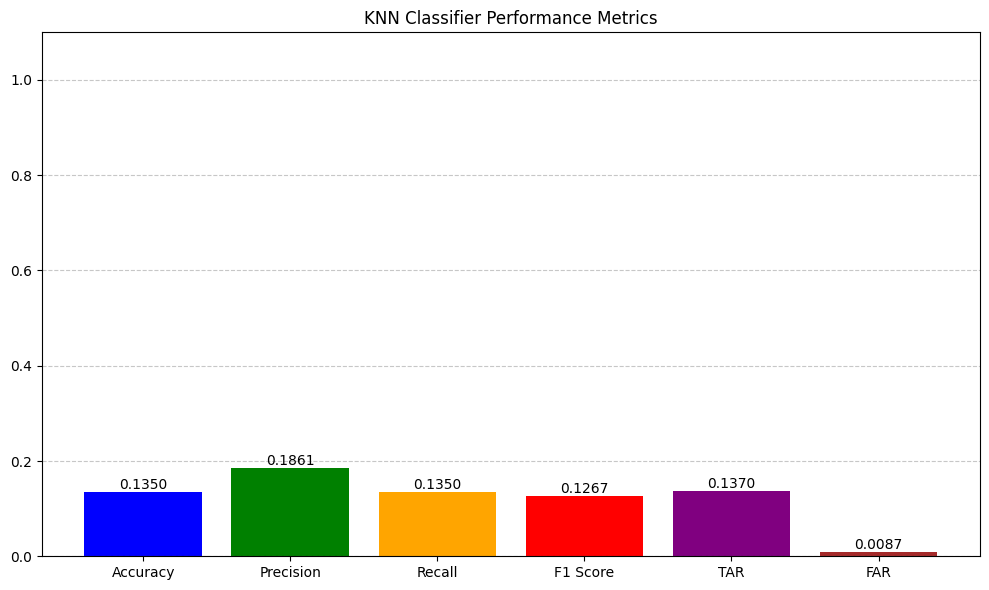

Metrics loaded and plotted successfully.


In [24]:
def reload_saved_model_and_plot():

    with open(base_path / "metrics.json", "r") as f:
        metrics = json.load(f)

    plot_results(metrics)

    print("Metrics loaded and plotted successfully.")

if __name__ == "__main__":
    reload_saved_model_and_plot()

In [25]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def load_model_and_evaluate(X_test_raw, y_test, base_path):
    # Load saved objects
    with open(Path(base_path) / 'knn_model.pkl', 'rb') as f:
        knn_model = pickle.load(f)
    with open(Path(base_path) / 'pca.pkl', 'rb') as f:
        pca = pickle.load(f)
    with open(Path(base_path) / 'scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Preprocess test data
    X_scaled = scaler.transform(X_test_raw)
    X_pca = pca.transform(X_scaled)

    # Predict and evaluate
    y_pred = knn_model.predict(X_pca)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return y_pred


In [15]:
X_train, y_train, X_test, y_test = load_and_preprocess_data()

y_pred = load_model_and_evaluate(X_test, y_test, base_path)


Loading CIFAR-100 dataset...
Data loaded and preprocessed.
Training data shape: (50000, 3072)
Testing data shape: (10000, 3072)
Number of classes: 100
Accuracy: 0.1264
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.39      0.42       100
           1       0.33      0.13      0.19       100
           2       0.11      0.02      0.03       100
           3       0.12      0.02      0.03       100
           4       0.06      0.16      0.09       100
           5       0.08      0.02      0.03       100
           6       0.50      0.03      0.06       100
           7       0.03      0.04      0.03       100
           8       0.11      0.09      0.10       100
           9       0.31      0.27      0.29       100
          10       0.07      0.04      0.05       100
          11       0.00      0.00      0.00       100
          12       0.17      0.02      0.04       100
          13       0.50      0.01      0.02       1

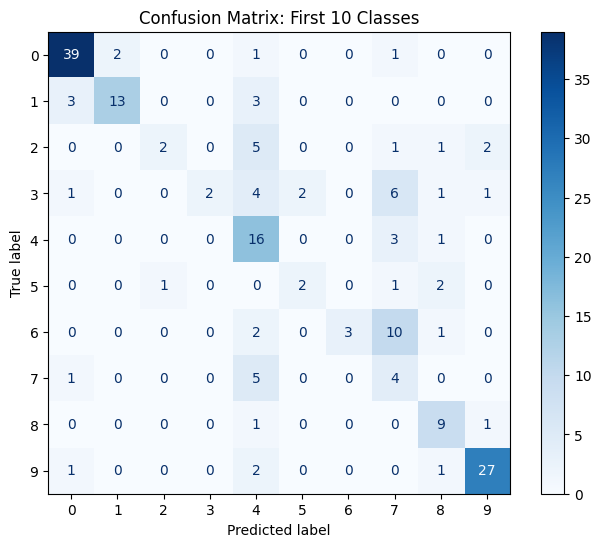

In [19]:
cm = confusion_matrix(y_test, y_pred)

subset_classes = list(range(10))
cm_subset = cm[np.ix_(subset_classes, subset_classes)]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_subset, display_labels=subset_classes)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix: First 10 Classes")
plt.show()